In [1]:
script = False
cluster = False

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

import segmentation_models_pytorch as smp

import seaborn as sn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps
import cv2

#from transformers import ViTFeatureExtractor, ViTForImageClassification

from memory_profiler import memory_usage
import random
import os
import gc
from astropy.io import fits

from skimage import io
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

if(script):
    from tqdm import tqdm
else: 
    from tqdm.notebook import tqdm

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        """
        #Plotting with Astropy and saving as png (not used right now)
        print('Astropy')
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.savefig('Image.png', bbox_inches='tight')
        plt.close()
        new_image = Image.open('Image.png')
        return(new_image)
        """
        #new_image = np.empty((3, 46, 46)) #I NEED TO CHANGE MY IMAGE SIZES!!!!!!
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(new_image)).convert("RGB")
        new_image = self.transform(new_image)
        
        label = self.labels[idx]
        label = cv2.resize(label, (96, 96), interpolation=cv2.INTER_NEAREST)
        label = torch.from_numpy(label)[None, :]
        
        data_point = self.data.iloc[idx].to_dict()
                                
        sample = {'image': new_image, 'label': label, 'img': image, 'data': data_point}
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    #y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [5]:
seed_everything(9)

if(cluster):
    path = '/data/des90.a/data/sgonzal/training_data/' #DES cluster
    path = 'Data/' #CHTC
else:
    path = '' #local
    

npos = 4000

num_workers = 0
num_epochs = 20


hdu_list = fits.open(path + 'labeled_file.fits')
idx = random.sample(range(len(hdu_list[1].data)), npos)
images = hdu_list[2].data[idx,:] 
images = images.astype(np.float32)
labels = hdu_list[4].data[idx,:] 
#labels = labels.astype('int32')
labels = labels.astype(np.float32)
data = pd.DataFrame(hdu_list[6].data[:][idx])
data = data.drop('TILENAME', axis=1)
hdu_list.close()

transform = transforms.Compose([
            transforms.Resize((96, 96)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

print(images.shape, labels.shape)


(4000, 3, 45, 45) (4000, 45, 45)


In [6]:
def make_graphs1(name, sim_i, sim_r, sim_g, label):
    loc = plticker.MultipleLocator(base=3.75)
    fig, (ax1, ax2) = plt.subplots(figsize=(15, 4), ncols=2)

    rgb = make_lupton_rgb(sim_i, sim_r, sim_g, Q=11., stretch=40.)
    ax1.set_title('Image')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    original = ax1.imshow(rgb, aspect='equal')
    
    img3 = ax2.imshow(label)
    ax2.set_title('Mask')
    plt.colorbar(img3, ax=ax2)
    #ax2.axis('off')
   
    sub_path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
    #plt.savefig(sub_path + 'Data/Sim_complete/Image' + name + '.png', bbox_inches='tight')
    plt.show()

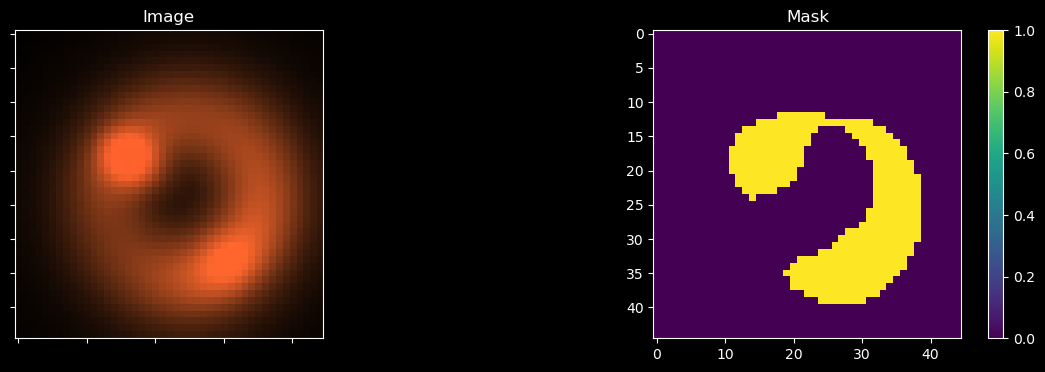

In [7]:
make_graphs1('name', images[0][2], images[0][1], images[0][0], labels[0])

In [8]:
train_dataset, other_dataset = make_train_test_datasets(images, data, labels, test_size=0.2, transform=transform)
valid_dataset, test_dataset = make_train_test_datasets(other_dataset.images, other_dataset.data, other_dataset.labels, test_size=0.5, transform=transform)
print('Len train dataset: {}, len test dataset: {}'.format(len(train_dataset), len(test_dataset)))

Len train dataset: 3200, len test dataset: 400


In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=10, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=5, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, num_workers=num_workers, shuffle=True)
torch.save(test_loader, 'test_loader.pth')

In [10]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        #self.model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
        self.model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=1)
        
        #self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        #self.model = timm.create_model("vit_base_patch16_224")
        #if(pretrained):
        #    path = 'jx_vit_base_p16_224-80ecf9dd.pth'
        #    self.model.load_state_dict(torch.load(path))

        #self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):

        x = self.model(x)

        return x

    def pseudo_accuracy(self, output, target):
        output = torch.sigmoid(output)
        num = target.size(0)
        m1 = output.view(num, -1)  # Flatten
        m2 = target.view(num, -1)  # Flatten
        intersection = (m1 * m2).sum()#(dim=1)
        #accu = intersection.item()*100/(96*96*num)
        return(2. * intersection + 1.) / (m1.sum() + m2.sum() + 1.)
        
    
    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################

        self.model.train()

        #for i, (data, target, sample_img, sample_data) in tqdm(enumerate(train_loader)):
        for i, sample in enumerate(tqdm(train_loader)):

            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            #output = torch.squeeze(output)

            #target = target.float()
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Calculate Accuracy
            #accuracy = (output.argmax(dim=1) == target).float().mean()
            accuracy = self.pseudo_accuracy(output, target)
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            optimizer.step()

        return epoch_loss / len(train_loader.dataset), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for i, sample in enumerate(tqdm(valid_loader)):
            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                #accuracy = (output.argmax(dim=1) == target).float().mean()
                #accuracy = sum(output.argmax(dim=1) == target)
                accuracy = self.pseudo_accuracy(output, target)
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader.dataset), valid_accuracy / len(valid_loader)
    

In [11]:
model = ViTBase16(n_classes=9, pretrained=True)

criterion = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss() #nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


cpu


In [12]:
def fit_tpu(model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    
    best_val_acc = 0.0 # track of best accuracy

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        
        print(f"{'=' * 100}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        # moves towards valid_loader
        print("start valid_loader")

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            if(valid_acc > best_val_acc):
                setattr(model, 'loss_train', train_losses)
                setattr(model, 'loss_valid', valid_losses)
                setattr(model, 'train_acc', train_accs)
                setattr(model, 'validation_acc', valid_accs)
                torch.save(model, name_model)
                best_val_acc = valid_acc
                

In [13]:
def plot_performance(cnn):
    loss_train = [x.item() for x in cnn.loss_train]
    loss_valid = [x.item() for x in cnn.loss_valid]
    train_acc = [x.item() for x in cnn.train_acc]
    valid_acc = [x.item() for x in cnn.validation_acc]
    
    x = np.linspace(1,len(cnn.loss_train),len(cnn.loss_train))
    fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
    
    ax1.set_title('Losses')
    ax1.set_xlabel('Epoch')
    ax1.scatter(x, loss_train, color = 'skyblue', alpha = 0.8, label = 'Training loss')
    ax1.scatter(x, loss_valid, color = 'limegreen', alpha = 0.8,  label = 'Validation loss')
    ax1.legend()
    
    ax2.set_title('Performance. Max: {:.4f}%'.format(100*cnn.validation_acc[-1].item()))
    ax2.set_xlabel('Epoch')
    ax2.scatter(x, train_acc, color = 'skyblue', alpha = 0.8,  label = 'Training Accuracy')
    ax2.scatter(x, valid_acc, color = 'limegreen', alpha = 0.8,  label = 'Validation Accuracy')
    ax2.legend()
    
    if(script):
        plt.savefig('Performance.png', bbox_inches='tight')
        plt.close()
    else: 
        plt.show(block=True)
    

In [14]:
name_model = 'model.pt'
#                          model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
mem_usage = memory_usage(( fit_tpu, (model, name_model, num_epochs, device, criterion, optimizer, train_loader, valid_loader)))


EPOCH 1 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 1 - LOSS: 0.0375337153673172, ACCURACY: 0.45409995317459106

start valid_loader
EPOCH 1 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.07247702777385712, ACCURACY: 0.49329060316085815

EPOCH 2 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 2 - LOSS: 0.03202727437019348, ACCURACY: 0.5265812277793884

start valid_loader
EPOCH 2 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.06064439192414284, ACCURACY: 0.5514315366744995

EPOCH 3 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 3 - LOSS: 0.030790694057941437, ACCURACY: 0.5496381521224976

start valid_loader
EPOCH 3 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.06997428834438324, ACCURACY: 0.5306105017662048

EPOCH 4 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 4 - LOSS: 0.030222907662391663, ACCURACY: 0.5581907629966736

start valid_loader
EPOCH 4 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.08317573368549347, ACCURACY: 0.4651586413383484

EPOCH 5 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 5 - LOSS: 0.029947398230433464, ACCURACY: 0.5633045434951782

start valid_loader
EPOCH 5 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.08908429741859436, ACCURACY: 0.4997347295284271

EPOCH 6 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 6 - LOSS: 0.029586324468255043, ACCURACY: 0.5690135955810547

start valid_loader
EPOCH 6 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.07923849672079086, ACCURACY: 0.4880986213684082

EPOCH 7 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 7 - LOSS: 0.02942390739917755, ACCURACY: 0.570647120475769

start valid_loader
EPOCH 7 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.11100026220083237, ACCURACY: 0.40994930267333984

EPOCH 8 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 8 - LOSS: 0.02909577451646328, ACCURACY: 0.5750212669372559

start valid_loader
EPOCH 8 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.060056641697883606, ACCURACY: 0.5648073554039001

EPOCH 9 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 9 - LOSS: 0.02906772866845131, ACCURACY: 0.5767999887466431

start valid_loader
EPOCH 9 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.06007400155067444, ACCURACY: 0.565754771232605

EPOCH 10 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 10 - LOSS: 0.02895469218492508, ACCURACY: 0.5767903923988342

start valid_loader
EPOCH 10 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.06899401545524597, ACCURACY: 0.5079767107963562

EPOCH 11 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 11 - LOSS: 0.02877090685069561, ACCURACY: 0.5795356631278992

start valid_loader
EPOCH 11 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.07383166998624802, ACCURACY: 0.5077906847000122

EPOCH 12 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 12 - LOSS: 0.028518805280327797, ACCURACY: 0.5838717818260193

start valid_loader
EPOCH 12 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.07037612795829773, ACCURACY: 0.5004662275314331

EPOCH 13 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 13 - LOSS: 0.0286132600158453, ACCURACY: 0.5811852812767029

start valid_loader
EPOCH 13 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.10214652866125107, ACCURACY: 0.4237080514431

EPOCH 14 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 14 - LOSS: 0.02849373035132885, ACCURACY: 0.5838295817375183

start valid_loader
EPOCH 14 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.06449705362319946, ACCURACY: 0.5076378583908081

EPOCH 15 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 15 - LOSS: 0.028267784044146538, ACCURACY: 0.586151659488678

start valid_loader
EPOCH 15 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.0752246305346489, ACCURACY: 0.517772912979126

EPOCH 16 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 16 - LOSS: 0.028087608516216278, ACCURACY: 0.5888405442237854

start valid_loader
EPOCH 16 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.06969734281301498, ACCURACY: 0.5134122967720032

EPOCH 17 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 17 - LOSS: 0.02798021025955677, ACCURACY: 0.5904127359390259

start valid_loader
EPOCH 17 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.05971215292811394, ACCURACY: 0.5747948884963989

EPOCH 18 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 18 - LOSS: 0.02782336249947548, ACCURACY: 0.5919440388679504

start valid_loader
EPOCH 18 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.07770054042339325, ACCURACY: 0.4727397859096527

EPOCH 19 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 19 - LOSS: 0.027485430240631104, ACCURACY: 0.5963124632835388

start valid_loader
EPOCH 19 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.061434730887413025, ACCURACY: 0.5754000544548035

EPOCH 20 - TRAINING...


  0%|          | 0/320 [00:00<?, ?it/s]


	[TRAIN] EPOCH 20 - LOSS: 0.02743665874004364, ACCURACY: 0.5971388816833496

start valid_loader
EPOCH 20 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.06252250075340271, ACCURACY: 0.5402302742004395



In [15]:
print('Maximum memory usage: %s' % max(mem_usage))


Maximum memory usage: 1948.1171875


In [16]:
name = 'model.pt'#'model.pt'#'other.pt' 
model = torch.load(name)
print('Maximum validation accuracy: {:.2f}%'.format(100*model.validation_acc[-1].item()))


Maximum validation accuracy: 57.54%


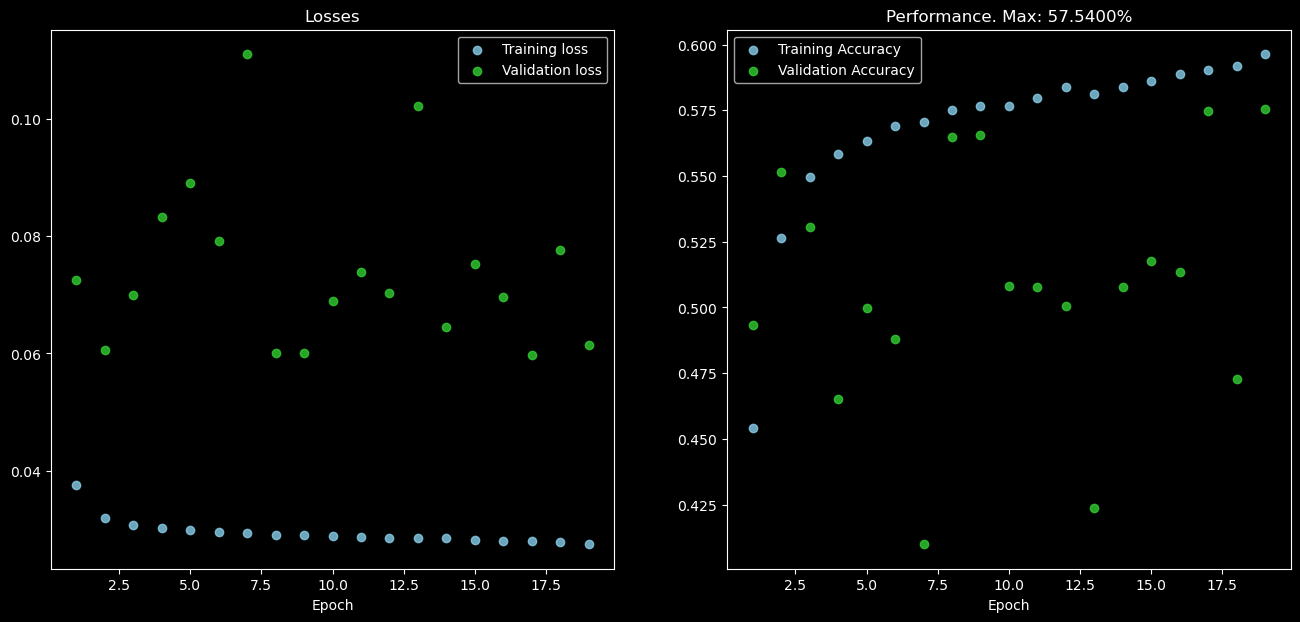

In [17]:
plot_performance(model)

In [18]:
def make_graphs(name, image, label, predicted_label):
    image = image[0]
    image = torch.sigmoid(image)
    
    loc = plticker.MultipleLocator(base=3.75)
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), ncols=3)

    rgb = make_lupton_rgb(image[2], image[1], image[0], Q=-100., stretch=1000.)
    ax1.set_title('Image')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    original = ax1.imshow(rgb, aspect='equal')
    
    img2 = ax2.imshow(label[0][0].detach().numpy())
    ax2.set_title('True Label')
    plt.colorbar(img2, ax=ax2)
    #ax2.axis('off')
    
    img3 = ax3.imshow(predicted_label[0][0].detach().numpy())
    ax3.set_title('Predicted')
    plt.colorbar(img3, ax=ax3)
    #ax2.axis('off')
   
    #plt.savefig(sub_path + 'Data/Sim_complete/Image' + name + '.png', bbox_inches='tight')
    plt.show()

In [21]:
def testing_analysis(accu_lim, test_loader):
    right_pos_img, wrong_pos_img = np.zeros((1,3,45,45)), np.zeros((1,3,45,45))
    right_neg_img, wrong_neg_img = np.zeros((1,3,45,45)), np.zeros((1,3,45,45))

    for i_batch, sample in enumerate(tqdm(test_loader)):
        if(i_batch == 15): break
        sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
        print(type(sample_image))
        
        if device.type == "cuda":
            sample_image, sample_label = sample_image.cuda(), sample_label.cuda()
        
        output = model(sample_image)  
        output = torch.sigmoid(output)
        make_graphs('name', sample_image, sample_label, output)
        
    #return(images)

  0%|          | 0/400 [00:00<?, ?it/s]

<class 'torch.Tensor'>


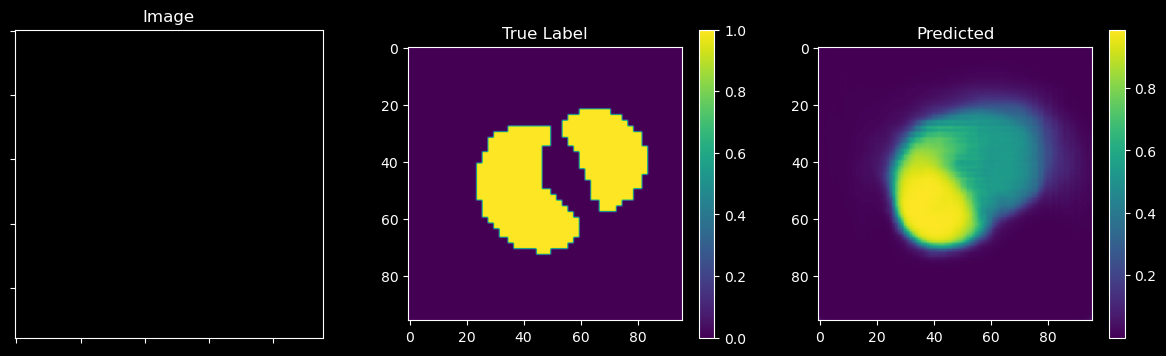

<class 'torch.Tensor'>


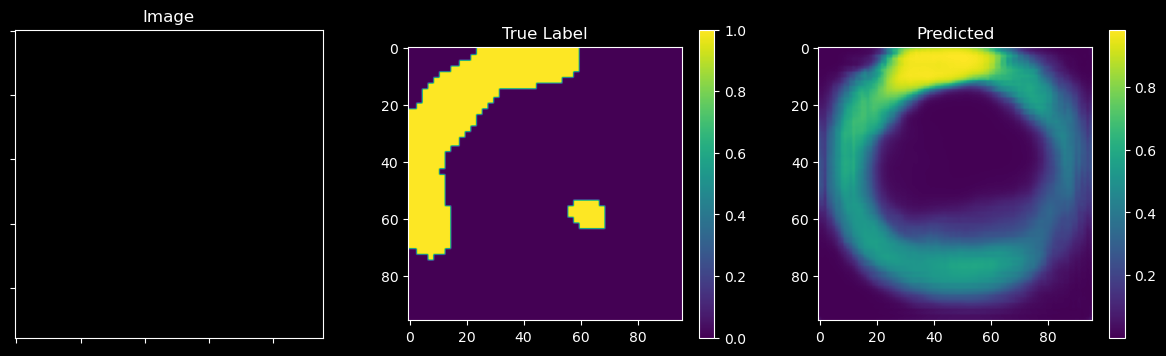

<class 'torch.Tensor'>


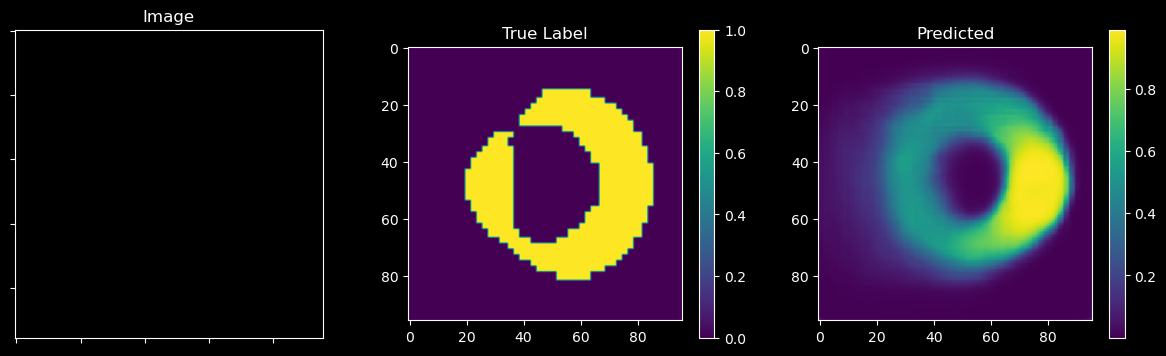

<class 'torch.Tensor'>


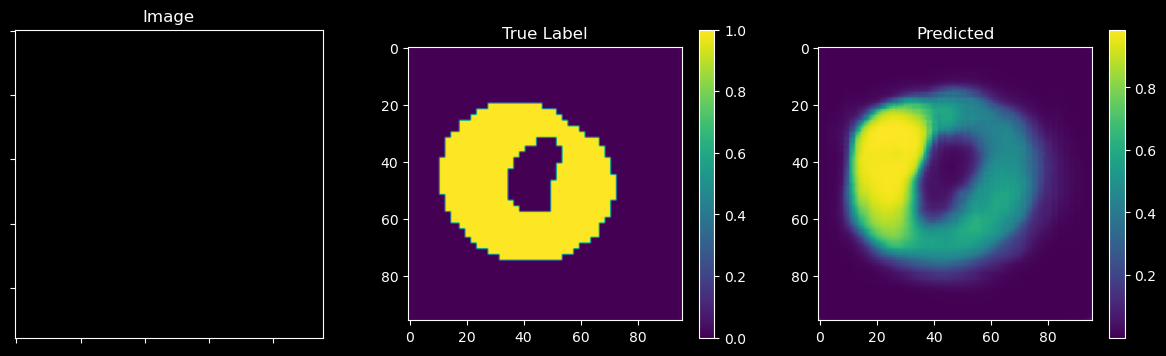

<class 'torch.Tensor'>


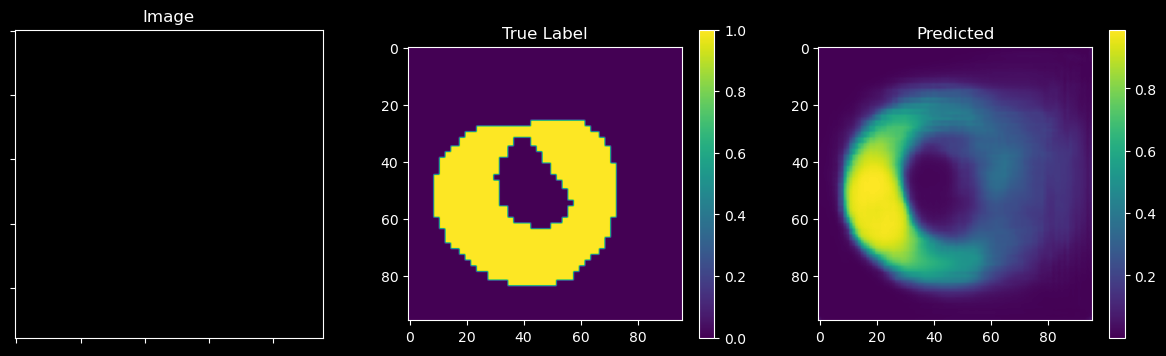

<class 'torch.Tensor'>


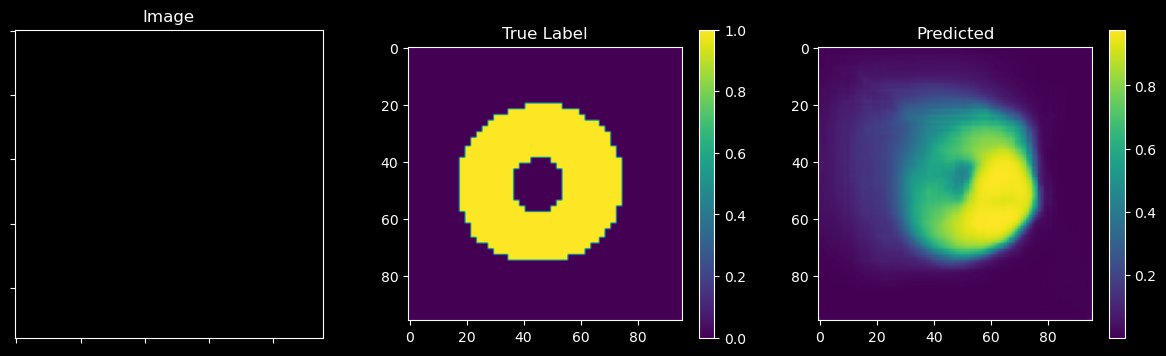

<class 'torch.Tensor'>


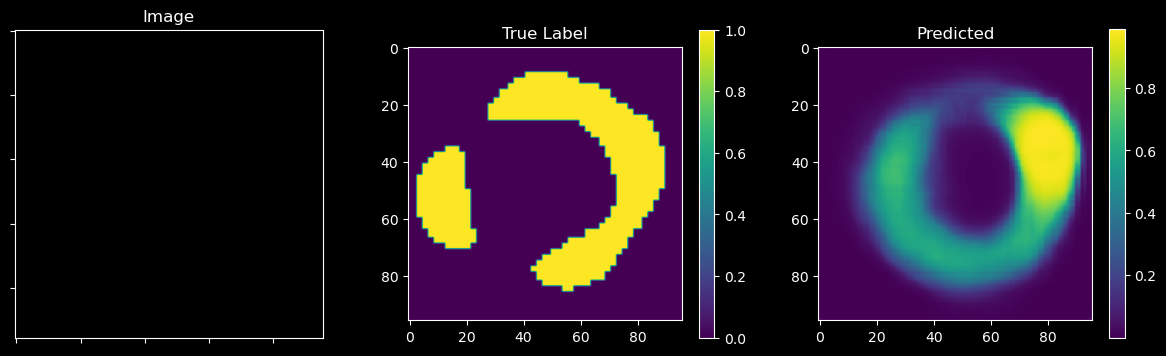

<class 'torch.Tensor'>


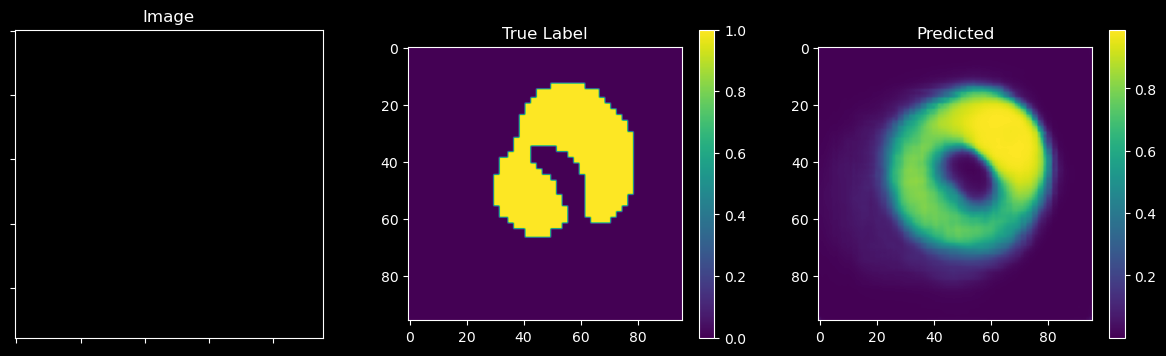

<class 'torch.Tensor'>


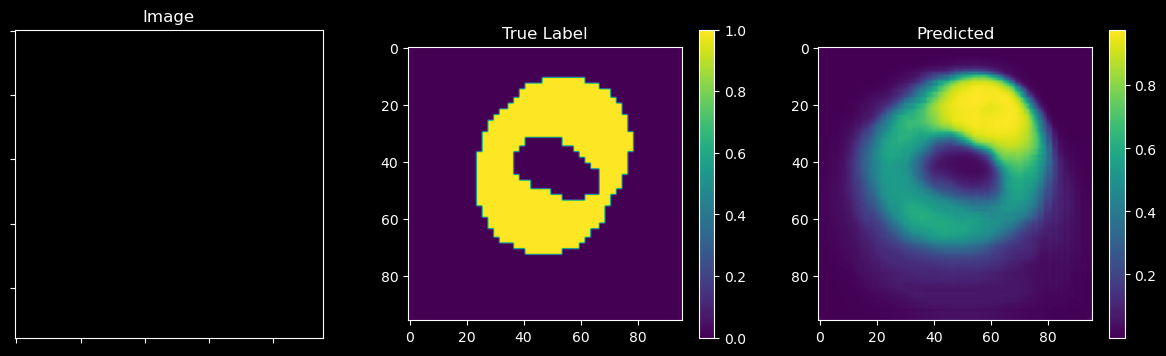

<class 'torch.Tensor'>


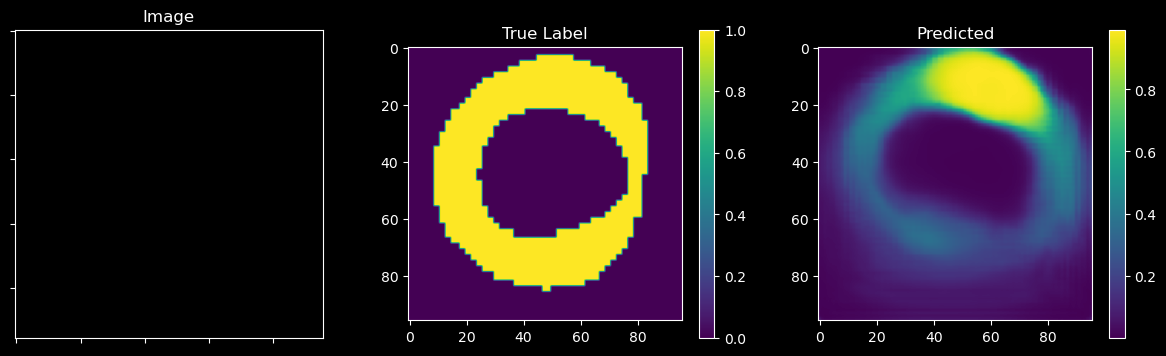

<class 'torch.Tensor'>


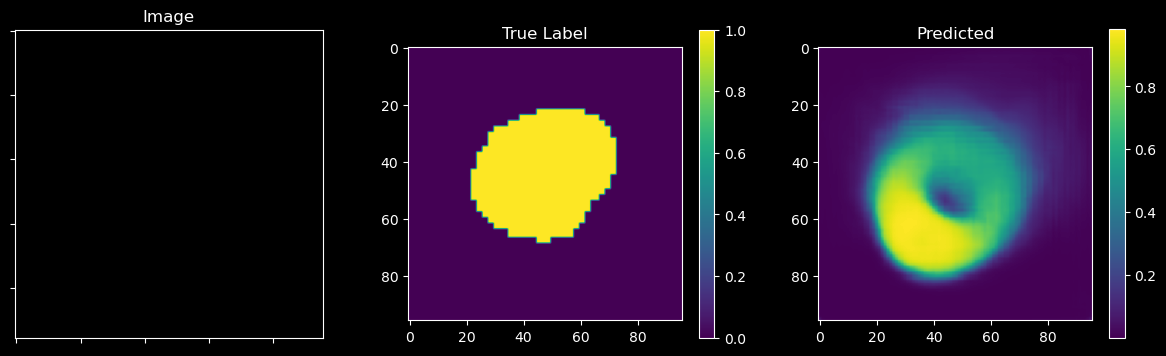

<class 'torch.Tensor'>


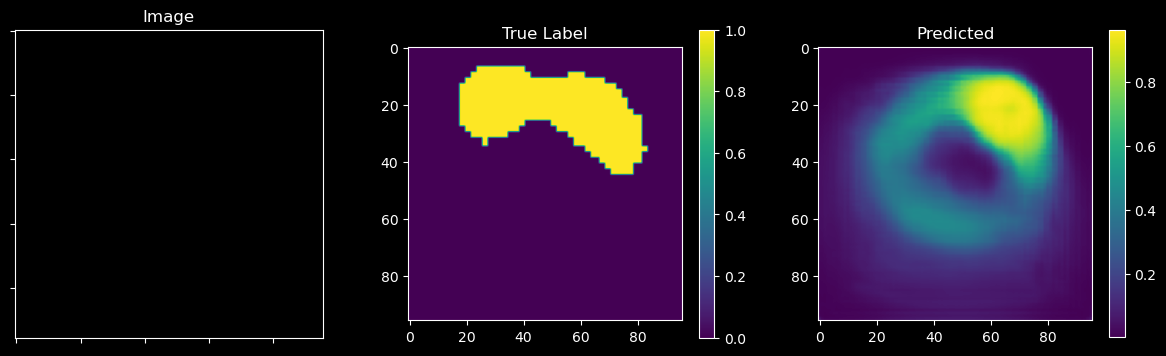

<class 'torch.Tensor'>


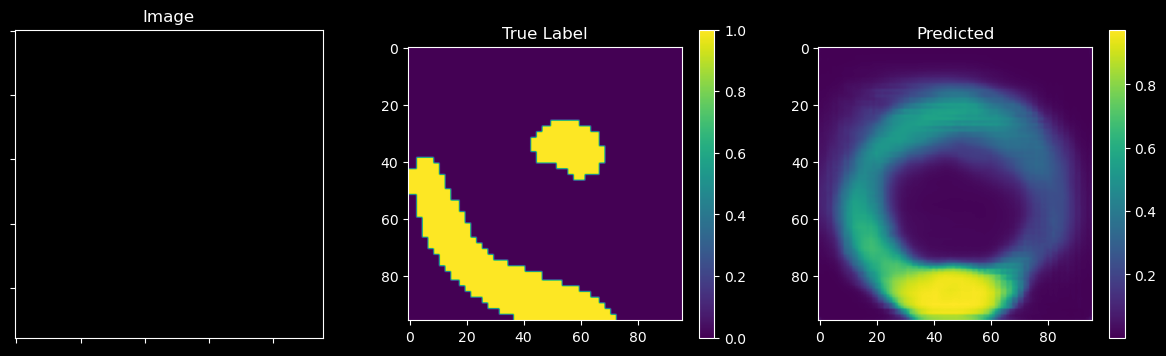

<class 'torch.Tensor'>


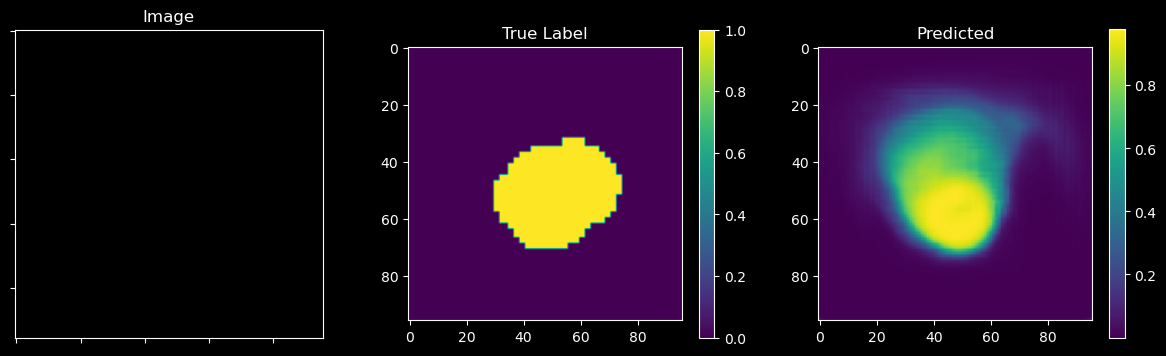

<class 'torch.Tensor'>


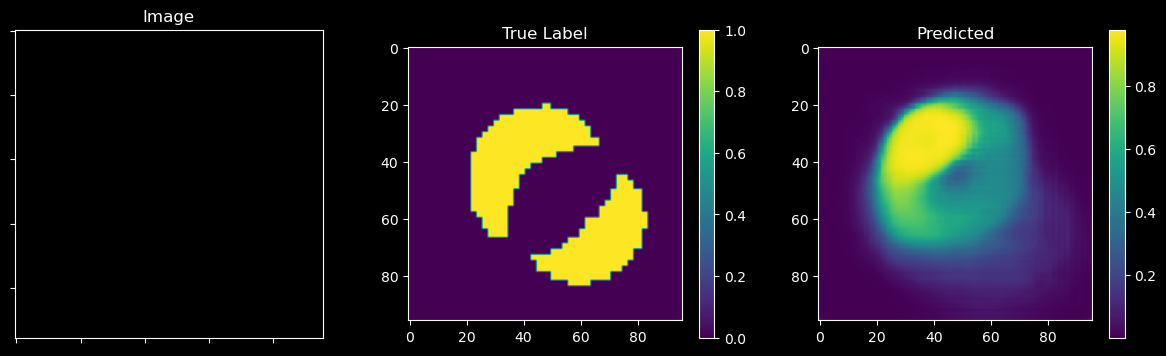

In [22]:
testing_analysis(0.5, test_loader)